<a href="https://colab.research.google.com/github/da-roth/StableAndBiasFreeMonteCarloGreeks/blob/main/src/Examples_Introduction/example_continued_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf, erfinv

class DigitalCallPricer:

    # Define constants as class attributes
    t_0 = 0.0
    m = 1
    T = 1.0
    r = 0.04
    sigma = 0.3
    K = 50
    N = 100000

    @staticmethod
    def bs_digital_closed(s_0, q = 0):
        # see e.g. https://en.wikipedia.org/wiki/Binary_option
        # Here: up-and-out digital call, or "Asset or nothing call"
        # This pays out one unit of spot if the spot is above the strike at maturit
        K = DigitalCallPricer.K
        sigma = DigitalCallPricer.sigma
        T = DigitalCallPricer.T
        r = DigitalCallPricer.r
        sigma_t = sigma * np.sqrt(T)
        tau = T - 0
        # Vanilla price
        d1 = (np.log(s_0/K) + (r-q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d2 = (np.log(s_0/K) + (r-q - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        # up and out price
        return s_0 * np.exp(-q * tau) * norm.cdf(d1)

    @staticmethod
    def MC_naive_torch(s_0):
        return DigitalCallPricer.MC_naive_generic_torch(s_0, DigitalCallPricer.path_update_GBM)

    @staticmethod
    def MC_BB_torch(s_0):
        return DigitalCallPricer.MC_oneStepSurvival_torch(s_0, DigitalCallPricer.path_update_GBM)

    @staticmethod
    def MC_naive_generic_torch(s_0, path_update_method):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        m_torch = torch.tensor(DigitalCallPricer.m, device=device)
        T_torch = torch.tensor(DigitalCallPricer.T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(DigitalCallPricer.r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(DigitalCallPricer.sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(DigitalCallPricer.K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(DigitalCallPricer.N, device=device)

        # Simulartion
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch_t0 = s_0_torch.expand(N_torch).clone()
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch

        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        s_torch = path_update_method(s_torch, dt_torch, z_torch, r_torch, sigma_torch)
        index = (torch.isnan(V) & (s_torch < K_torch))
        V[index] = 0.0

        #Payoff calculation
        index = torch.isnan(V)
        V[index] = torch.exp(-r_torch * T_torch) * s_torch[index]

        V = torch.sum(V[index]) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def MC_oneStepSurvival_torch(s_0, path_update_method):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        m_torch = torch.tensor(DigitalCallPricer.m, device=device)
        T_torch = torch.tensor(DigitalCallPricer.T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(DigitalCallPricer.r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(DigitalCallPricer.sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(DigitalCallPricer.K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(DigitalCallPricer.N, device=device)
        two_torch = torch.tensor(2.0, device=device)
        # Simulation
        survival_prob = torch.full((N_torch,), 1.0, dtype=torch.float64, device=device)
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch

        z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
        # new try:
        u_torch = 0.5 * (1 + torch.erf(z_torch / torch.sqrt(torch.tensor(2.0))))
        oss_prob = 0.5 * (torch.erf((torch.log(K_torch / s_torch) - (r_torch - 0.5 * sigma_torch**2) * dt_torch) / (sigma_torch * torch.sqrt(dt_torch)) / torch.sqrt(two_torch)) + 1.0)
        s_torch_new = s_torch * torch.exp((r_torch- 0.5 * sigma_torch**2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * torch.erfinv(2 * ((1-oss_prob) * u_torch + oss_prob) - 1) * torch.sqrt(two_torch))

        #Payoff calculation
        V = (1 - oss_prob) * torch.exp(-r_torch * T_torch) * s_torch_new
        V = torch.sum(V) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def path_update_GBM(s_torch, dt_torch, z_torch, r_torch, sigma_torch):
        return s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

    @staticmethod
    def compute_delta_finite_differences(s_0, hDif, method):
        if method == 'naive':
            a_value, _ = DigitalCallPricer.MC_naive_torch(s_0)
            b_value, _ = DigitalCallPricer.MC_naive_torch(s_0 + hDif)
        elif method == 'closed':
            a_value = DigitalCallPricer.bs_digital_closed(s_0)
            b_value = DigitalCallPricer.bs_digital_closed(s_0 + hDif)
        elif method == 'OSS':
            a_value, _ = DigitalCallPricer.MC_BB_torch(s_0)
            b_value, _ = DigitalCallPricer.MC_BB_torch(s_0 + hDif)
        else:
            raise ValueError("Invalid method specified")
        delta_finite_differences = (b_value - a_value) / hDif
        return delta_finite_differences

    @staticmethod
    def compute_gamma_finite_differences(s_0, hDif, method):
        if method == 'naive':
            minus_value, _ = DigitalCallPricer.MC_naive_torch(s_0 - hDif)
            center_value, _ = DigitalCallPricer.MC_naive_torch(s_0)
            plus_value, _ = DigitalCallPricer.MC_naive_torch(s_0 + hDif)
        elif method == 'closed':
            minus_value = DigitalCallPricer.bs_digital_closed(s_0 - hDif)
            center_value = DigitalCallPricer.bs_digital_closed(s_0)
            plus_value = DigitalCallPricer.bs_digital_closed(s_0 + hDif)
        elif method == 'OSS':
            minus_value, _ = DigitalCallPricer.MC_BB_torch(s_0 - hDif)
            center_value, _ = DigitalCallPricer.MC_BB_torch(s_0)
            plus_value, _ = DigitalCallPricer.MC_BB_torch(s_0 + hDif)
        else:
            raise ValueError("Invalid method specified")

        gamma_finite_differences = (plus_value - 2 * center_value + minus_value) / (hDif ** 2)
        return gamma_finite_differences

    @staticmethod
    def compute_gamma_aad(s_0, hDif, method):
        if method == 'naive':
            _, delta_plus = DigitalCallPricer.MC_naive_torch(s_0 + hDif)
            _, delta_minus = DigitalCallPricer.MC_naive_torch(s_0 - hDif)
        elif method == 'OSS':
            _, delta_plus = DigitalCallPricer.MC_BB_torch(s_0 + hDif)
            _, delta_minus = DigitalCallPricer.MC_BB_torch(s_0 - hDif)
        else:
            raise ValueError("Invalid method specified")

        # Compute gamma using finite differences of the deltas
        gamma_aad = (delta_plus - delta_minus) / (2 * hDif)
        return gamma_aad

    @staticmethod
    def plot_present_values(s_0_array):
        values_closed = []
        values_naive = []
        values_BB= []
        difference_naive_BB = []
        for s_0 in s_0_array:
            value_closed = DigitalCallPricer.bs_digital_closed(s_0)
            value_naive, _ = DigitalCallPricer.MC_naive_torch(s_0)
            value_BB, _ = DigitalCallPricer.MC_BB_torch(s_0)

            values_closed.append(value_closed)
            values_naive.append(value_naive)
            values_BB.append(value_BB)
            difference_naive_BB.append(value_naive - value_BB)

        plt.figure(figsize=(10, 6))
        plt.plot(s_0_array, values_closed, label='present value closed solution', color='black' )
        #plt.plot(s_0_array, values_naive, label='present value naive Monte Carlo', marker='.', color='red')
        plt.plot(s_0_array, values_BB, label='Present Value BB', marker='x', color='green')
        plt.xlabel('$S_0$')
        plt.ylabel('Present Value')
        plt.title('present value comparison: closed solution vs modified MC')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_deltas(s_0_array, hDif):
        deltas_AAD_naive = []
        deltas_FD_naive = []
        deltas_FD_closed = []
        deltas_FD_BB = []
        deltas_AAD_BB = []

        for s_0 in s_0_array:
            delta_FD_closed = DigitalCallPricer.compute_delta_finite_differences(s_0, hDif, 'closed')
            _, delta_AAD_naive = DigitalCallPricer.MC_naive_torch(s_0)
            delta_FD_naive = DigitalCallPricer.compute_delta_finite_differences(s_0, hDif, 'naive')
            _, delta_AAD_BB = DigitalCallPricer.MC_BB_torch(s_0)
            delta_FD_BB = DigitalCallPricer.compute_delta_finite_differences(s_0, hDif, 'OSS')

            deltas_AAD_naive.append(delta_AAD_naive)
            deltas_FD_naive.append(delta_FD_naive)
            deltas_FD_closed.append(delta_FD_closed)
            deltas_AAD_BB.append(delta_AAD_BB)
            deltas_FD_BB.append(delta_FD_BB)

        plt.figure(figsize=(10, 6))
        plt.plot(s_0_array, deltas_FD_closed, label='Delta closed', color='black')
        #plt.plot(s_0_array, deltas_AAD_naive, label='Delta AAD standard MC', marker='.', color='red')
        #plt.plot(s_0_array, deltas_FD_naive, label='Delta FD standard MC', marker='x', color='orange')
        plt.plot(s_0_array, deltas_AAD_BB, label='Delta AAD modified MC', marker='x', color='green')
        plt.plot(s_0_array, deltas_FD_BB, label='Delta FD modified MC', color='yellow')
        plt.xlabel('$S_0$')
        plt.ylabel('Delta')
        plt.title('Delta Comparisons using FiniteDifferences vs. AAD')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_gammas(s_0_array, hDif):
        gammas_FD_naive = []
        gammas_FD_closed = []
        gammas_AAD_naive = []
        gammas_FD_BB = []
        gammas_AAD_BB = []

        for s_0 in s_0_array:
            gamma_FD_naive = DigitalCallPricer.compute_gamma_finite_differences(s_0, hDif, 'naive')
            gamma_FD_closed = DigitalCallPricer.compute_gamma_finite_differences(s_0, hDif, 'closed')
            gamma_AAD_naive = DigitalCallPricer.compute_gamma_aad(s_0, hDif, 'naive')
            gamma_FD_BB = DigitalCallPricer.compute_gamma_finite_differences(s_0, hDif, 'OSS')
            gamma_AAD_BB = DigitalCallPricer.compute_gamma_aad(s_0, hDif, 'OSS')
            gammas_FD_naive.append(gamma_FD_naive)
            gammas_FD_closed.append(gamma_FD_closed)
            gammas_AAD_naive.append(gamma_AAD_naive)
            gammas_FD_BB.append(gamma_FD_BB)
            gammas_AAD_BB.append(gamma_AAD_BB)

        plt.figure(figsize=(10, 6))
        plt.plot(s_0_array, gammas_FD_closed, label='Gamma closed', color='black')
        plt.plot(s_0_array, gammas_AAD_BB, label='Gamma AAD OSS', marker='x', color='green')
        plt.plot(s_0_array, gammas_FD_BB, label='Gamma FD OSS', color='yellow')

        plt.xlabel('$S_0$')
        plt.ylabel('Gamma')
        plt.title('Gamma Comparisons using Finite Differences vs. AAD')
        plt.legend()
        plt.grid(True)
        plt.show()

In [2]:
# Test the new function for computing delta using finite differences
s_0 = 50
hDif = 0.000001

# Compute delta through Automatic Differentiation (AAD)
a_value =  DigitalCallPricer.bs_digital_closed(s_0)

# Compute delta through Finite Differences
delta_FD = DigitalCallPricer.compute_delta_finite_differences(s_0, hDif, 'naive')

# Print the calculated value and delta
print("Present value digital call up out:", a_value)

# Print the results
#print("Delta through AAD:", delta_AAD)
print("Delta through finite differences:", delta_FD)

Present value digital call up out: 30.576966814736693
Delta through finite differences: 0.610792657340653


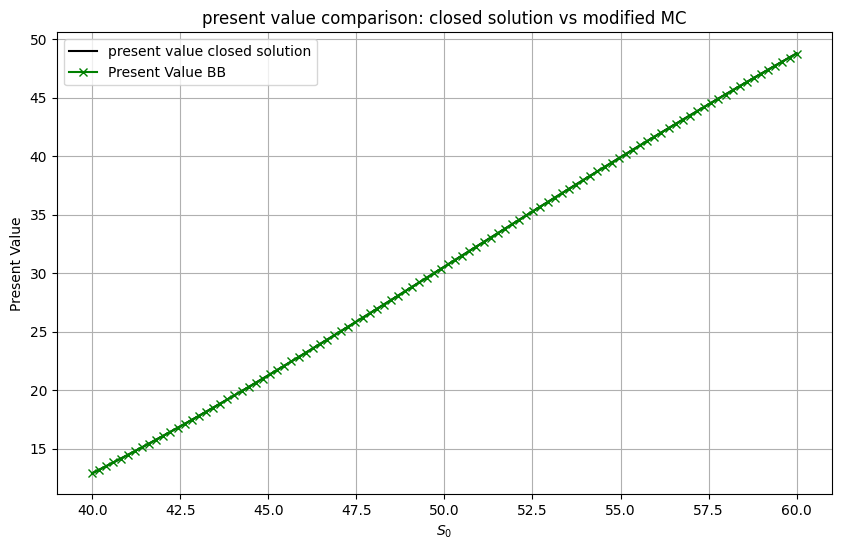

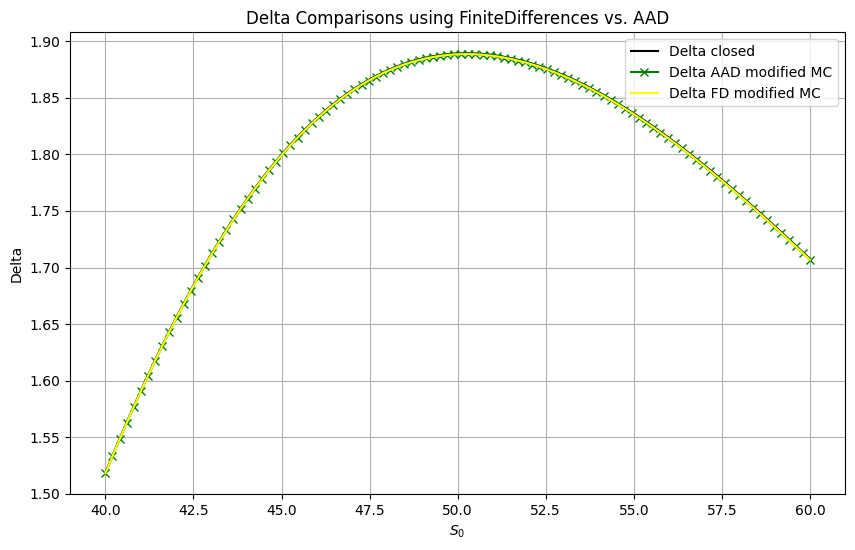

In [3]:
# Example array of s_0 values to test
s_0_values = np.linspace(40, 60, 100)
hDif = 0.0001

# Call the plotting functions
DigitalCallPricer.plot_present_values(s_0_values)
DigitalCallPricer.plot_deltas(s_0_values, hDif)
#DigitalCallPricer.plot_gammas(s_0_values, hDif)